In [2]:
# Import standard Python libraries.
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

# Install and import PyMC and Arviz libraries.

import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

# Install and import Yahoo Finance web scraper.
import yfinance as yf

# Fix random seed so that numerical results can be reproduced.
np.random.seed(101)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# Import financial data.
start = datetime(2022, 11, 15)
end = datetime(2022, 12, 31)

# S&P 500 index is a proxy for the market factor.
market = yf.Ticker('SPY').history(start=start, end=end)
# Ticker symbol for Apple, the largest company in the world by market capitalization.
stock = yf.Ticker('AAPL').history(start=start, end=end)
# 10 year US treasury note is the proxy for risk free rate.
riskfree_rate = yf.Ticker('^TNX').history(start=start, end=end)


In [18]:


# Create a dataframe to hold the daily returns of securities.
daily_returns = pd.DataFrame()
# Compute daily percentage returns based on closing prices for Apple and S&P 500 index.
daily_returns['market'] = market['Close'].pct_change(1)*100
daily_returns['stock'] = stock['Close'].pct_change(1)*100
# Compounded daily risk free rate based on 360 days for the calendar year used in the bond market.
test = (1 + riskfree_rate['Close']) ** (1 / 360) - 1
test = test.tz_localize(None)
daily_returns = daily_returns.tz_localize(None)

daily_returns['riskfree'] = test

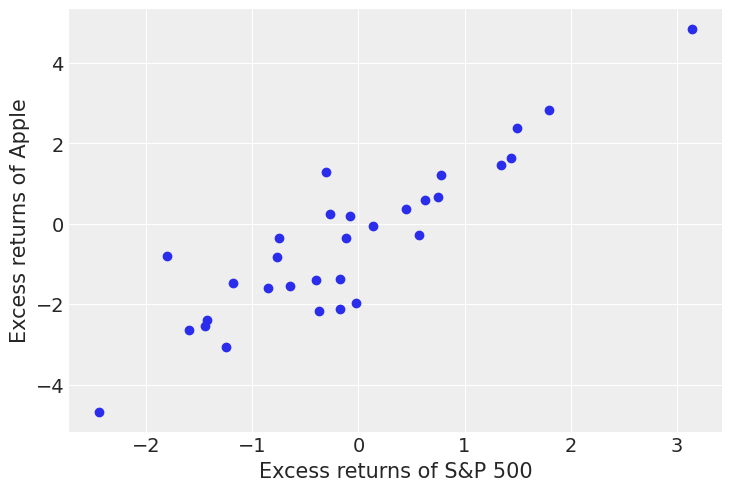

In [19]:
# Check for missing data in the dataframe.
market.index.difference(riskfree_rate.index)
# Fill rows with previous day's risk-free rate since daily rates are generally stable.
daily_returns = daily_returns.ffill()
# Drop NaNs in first row because of percentage calculations are based on previous day's closing price.
daily_returns = daily_returns.dropna()
# Check dataframe for null values.
daily_returns.isnull().sum()
# Check first five rows of dataframe.
daily_returns.head()

# Daily excess returns of AAPL are returns in excess of the daily risk free rate.
y = daily_returns['stock'] - daily_returns['riskfree']
# Daily excess returns of the market are returns in excess of the daily risk free rate.
x = daily_returns['market'] - daily_returns['riskfree']

# Plot the excess returns of Apple and S&P 500.
plt.scatter(x,y)
plt.ylabel('Excess returns of Apple'), plt.xlabel('Excess returns of S&P 500');

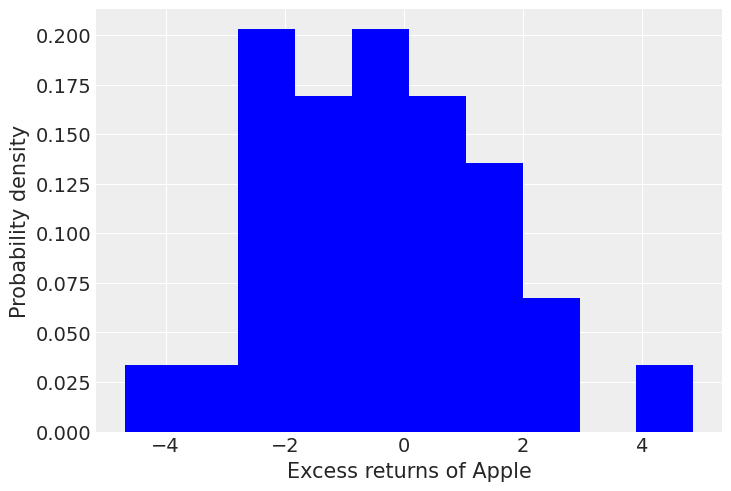

In [20]:
# Plot histogram of Apple's excess returns during the period.
plt.hist(y, density=True, color='blue')
plt.ylabel('Probability density'), plt.xlabel('Excess returns of Apple');

In [21]:
# Analyze daily returns of all securities.
daily_returns.describe()

,market,stock,riskfree
count,31.000000,31.000000,31.000000
mean,-0.110989,-0.444417,0.004282
std,1.192471,1.967499,0.000083
min,-2.446171,-4.685423,0.004129
25%,-0.805411,-1.775168,0.004200
50%,-0.171749,-0.343503,0.004299
75%,0.602695,0.635446,0.004340
max,3.150053,4.859403,0.004417


In [22]:
# Split time series sequentially because of serial correlation in financial data.
test_size = 10

x_train = x[:-test_size]
y_train = y[:-test_size]

x_test = x[-test_size:]
y_test = y[-test_size:]

In [23]:
# Create a probabilistic model by instantiating the PyMC model class.
model = pm.Model()

# The with statement creates a context manager for the model object.
# All variables and constants inside the with-block are part of the model.

with model:
  # Define the prior probability distributions of the model's parameters. Use prior domain knowledge.

  # Alpha quantifies the idiosyncratic, daily excess return of Apple unaffected by market movements.
  # Assume that alpha is normally distributed. The values of mu and sigma are based on previous data analysis and trial and error.
  alpha = pm.Normal('alpha', mu=0.02, sigma=0.10)

  # Beta quantifies the sensitivity of Apple to the movements of the market/S&P 500.
  # Assume that beta is normally distributed. The values of mu and sigma are based on previous data analysis and trial and error.
  beta = pm.Normal('beta', mu=1.2, sigma=0.15)

  # Residual quantifies the unexpected returns of Apple i.e returns not predicted by the linear model.
  # Assume residuals are Half Student's t-distribution with nu=6. Value of nu=6 is based on research studies and trial and error.
  residual = pm.HalfStudentT('residual', sigma=0.20, nu=6)

  # Mutatable data containers are used so that we can swap out training data for test data later.
  feature = pm.MutableData('feature', x_train, dims='feature_data')
  target = pm.MutableData('target', y_train, dims='target_data')

  # Expected daily excess returns of Apple are approximately linearly related to daily excess returns of S&P 500
  # The function specifies the linear model and the expected return. It creates a deterministic variable in the trace object.
  target_expected = pm.Deterministic('target_expected', alpha + beta * feature, dims='feature_data')

  # Assign the training data sample to the likelihood function.
  # Daily excess stock price returns are assumed to be T-distributed with nu=6.
  target_likelihood = pm.StudentT('target_likelihood', mu=target_expected, sigma=residual, nu=6, observed=target, dims='target_data')


D:\Programmes\Anaconda\envs\Proba_ML\Lib\site-packages\pymc\data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


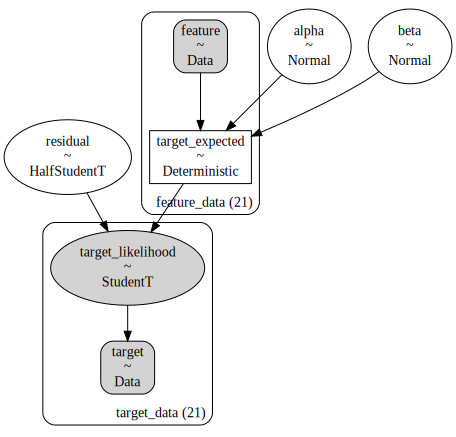

In [24]:
# The graphviz method is used to visualize the probabilistic model's data, parameters, distributions and dependencies.
pm.model_to_graphviz(model)

In [25]:
# Sample from the prior distributions and the likelihood function to generate prior predictive distribution of the model.
# Take 1000 draws from the prior predictive distribution to simulate (1000*21) target values based on our prior assumptions.
idata = pm.sample_prior_predictive(samples=1000, model=model, return_inferencedata=True, random_seed=101)

Sampling: [alpha, beta, residual, target_likelihood]


In [26]:
# PyMC/Arviz returns an xarray - a labeled, multidimensional array containing inference data samples structured into groups.
# Note the dimensions of the prior predictive group to see how we got (1*1000*21) simulated target data of the prior predictive distribution.
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

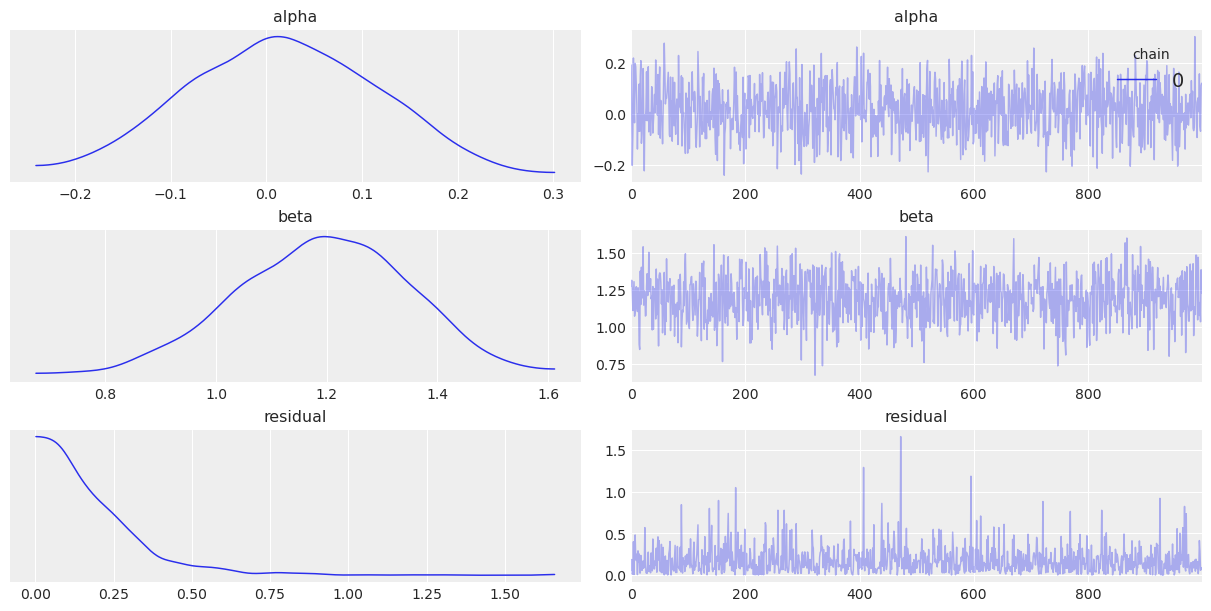

In [27]:
# Subplots on the left show the kernel density estimates (KDE) of the marginal prior probability distributions of model parameters from the 1000 samples drawn.
# Subplots on the right show the parameter values from a single Markov chain that were sampled sequentially by the NUTS sampler, the default regression sampler.
az.plot_trace(idata.prior, kind='trace', var_names = ['alpha', 'beta', 'residual'], legend=True);

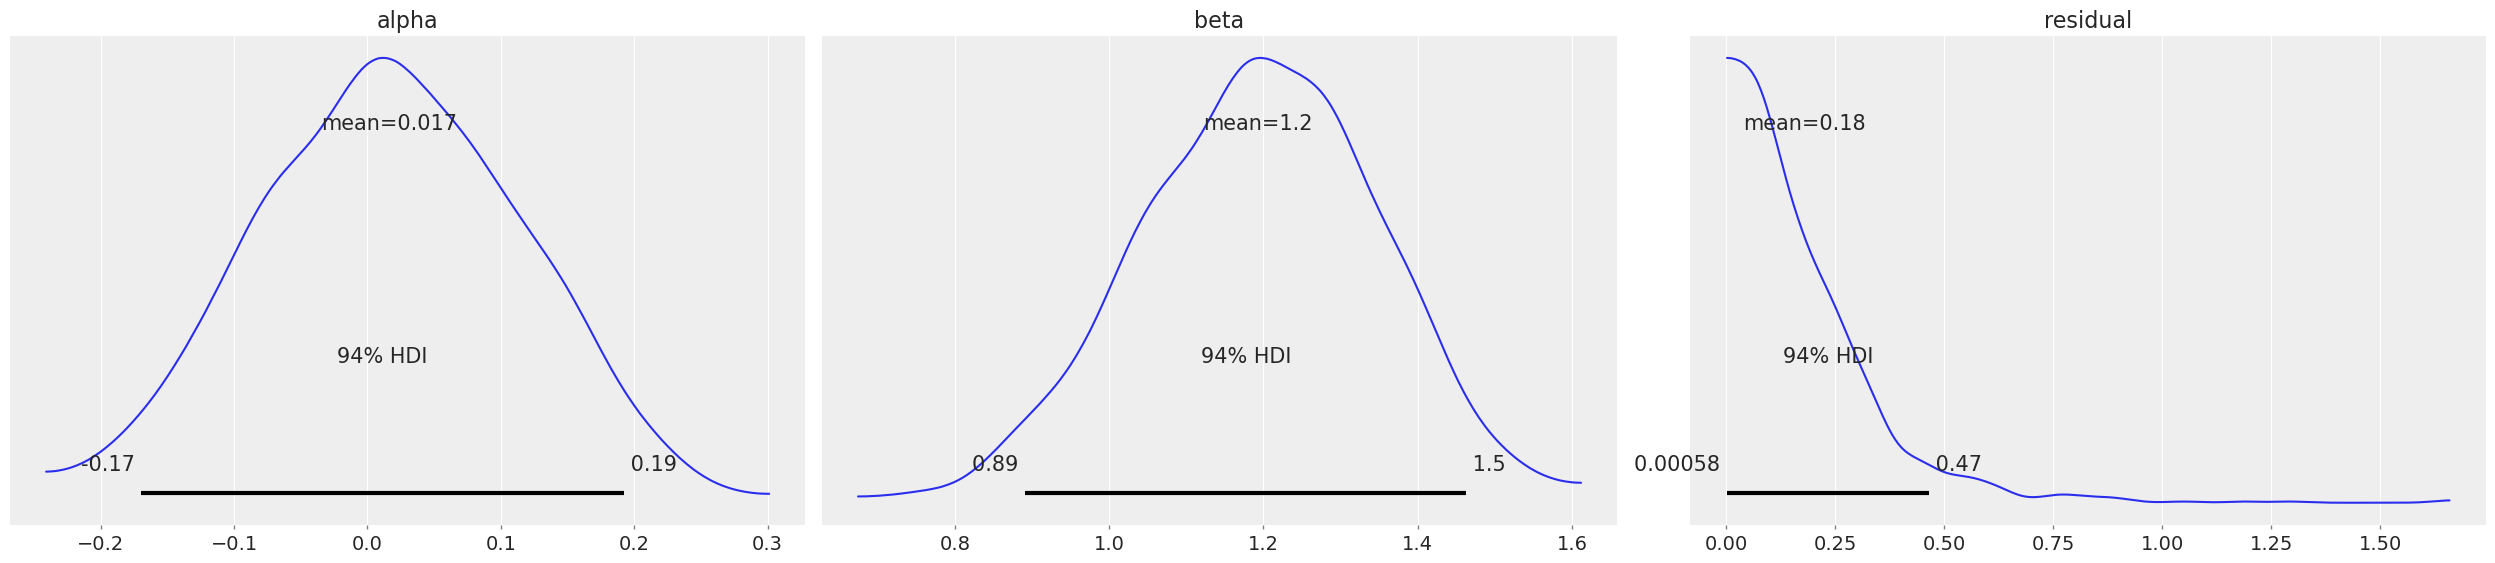

In [28]:
# Plot the marginal prior distributions of each parameter with 94% highest density intervals (HDI).
# Note the residual subplot shows the majority of probability density function within 3 percentage points and the rest extending out into a long tail.
# In Arviz, there is no method to plot the prior marginal distributions but we can hack the plot posterior method and use the prior group instead.
az.plot_posterior(idata.prior, var_names = ['alpha', 'beta', 'residual'], round_to=2);

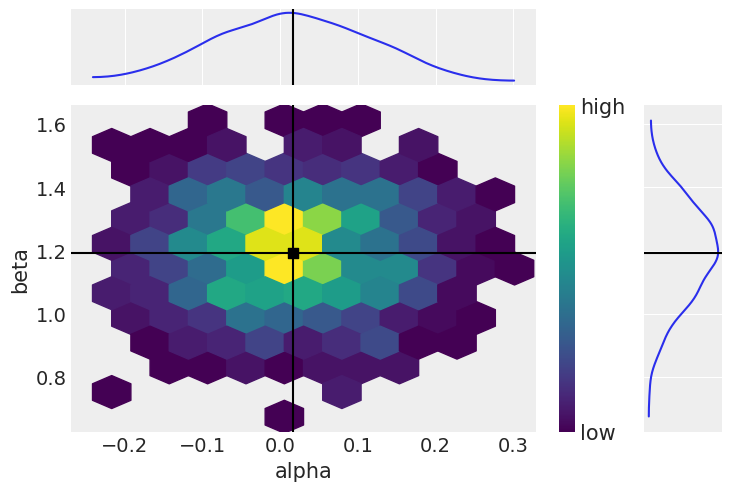

In [29]:
# Plot the joint prior probability distribution of alpha and beta with their respective means and marginal distributions on the side.
# Hexabin plot below shows little or no linear correlation with the high concentration areas in the heat map forming a cloud.
az.plot_pair(idata.prior, var_names=['alpha', 'beta'], kind='hexbin', marginals=True, point_estimate='mean', colorbar=True);

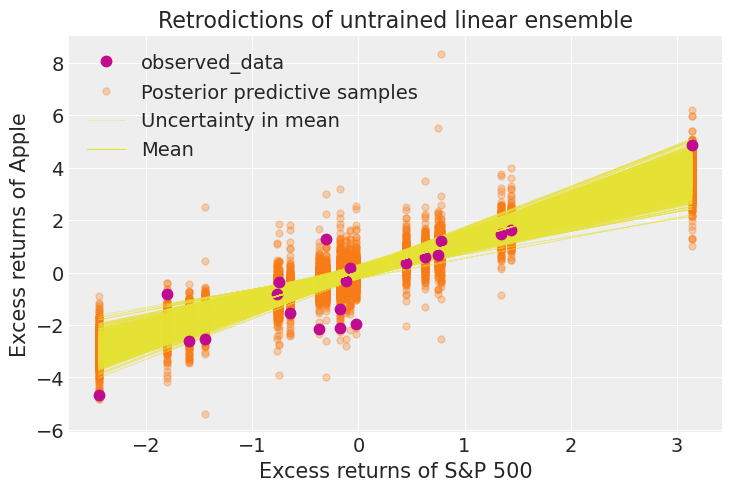

In [30]:
# Plot the retrodictions of prior predictive ensemble.

# Retrieve feature and target training data from the constant_data group.
# Feature is now an xarray instead of a Panda's series, a requirement for ArViz data analysis.
feature_train = idata.constant_data['feature']
target_train = idata.constant_data['target']

# Generate 1000 linear regression lines based on 1000 draws from one Markov chain of the prior distributions of alpha and beta.
# Prior target values are in 1000 arrays with each array having 21 samples, the same number of samples as our training data set.
prior_target = idata.prior["alpha"] + idata.prior["beta"] * feature_train

# Prior_predictive is the data generating distribution of the untrained ensemble.
prior_predictive = idata.prior_predictive['target_likelihood']

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot epistemic and aleatory uncertainties of untrained ensemble's retrodictions.
az.plot_lm(idata=idata, x=feature_train, y=target_train, num_samples=1000, y_model = prior_target, y_hat = prior_predictive, axes=ax)

# Label the figure.
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Retrodictions of untrained linear ensemble")
ax.legend(loc='upper left');


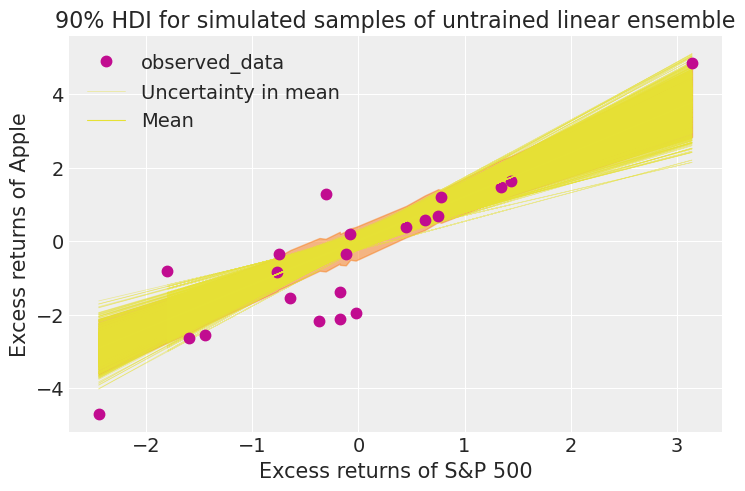

In [31]:
# Plot 90% HDI of untrained ensemble.
# This will show the aleatory (data related) and epistemic (parameter related) uncertainty of model output before it is trained.

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot the ensemble of 1000 regression lines to show the epistemic uncertainty around the mean regression line.
az.plot_lm(idata=idata, x=feature_train, y=target_train, num_samples=1000, y_model = prior_target, axes=ax)

# Plot the prior predictive data within the 90% HDI band to show both epistemic and aleatory uncertainties.
az.plot_hdi(feature_train, prior_predictive, hdi_prob=0.90, smooth=False)

# Label figure.
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("90% HDI for simulated samples of untrained linear ensemble")
ax.legend();

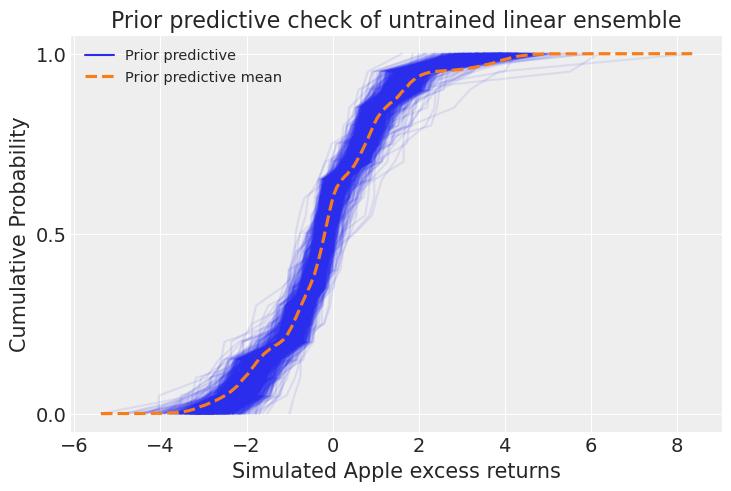

In [32]:
# Conduct a prior predictive check of the untrained linear ensemble.

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot the prior predictive check
az.plot_ppc(idata, group='prior', kind='cumulative', num_pp_samples=1000, alpha=0.1, ax=ax)

# Label the figure.
ax.set_xlabel("Simulated Apple excess returns")
ax.set_ylabel("Cumulative Probability")
ax.set_title("Prior predictive check of untrained linear ensemble");

In [33]:
# Evaluate untrained ensemble's retrodictions by comparing simulated data with training data.

# Extract target values of our training data.
target_actual = target_train.values

# Sample the prior predictive distribution to simulate expected target training values.
target_predicted = idata.prior_predictive.stack(sample=("chain", "draw"))['target_likelihood'].values.T

# Use the probabilistic R-squared metric.
prior_score = az.r2_score(target_actual, target_predicted)
prior_score.round(2)

r2        0.65
r2_std    0.09
dtype: float64

In [34]:
# Draw 1000 samples from two Markov chains resulting in 2000 values of each parameter to analyze the joint posterior distribution.
# Check for any divergences in the progress bar. We want 0 divergences for a reliable sampling of the posterior distribution.
idata.extend(pm.sample(draws=1000, chains=2, model=model, random_seed=101))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, residual]


D:\Programmes\Anaconda\envs\Proba_ML\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


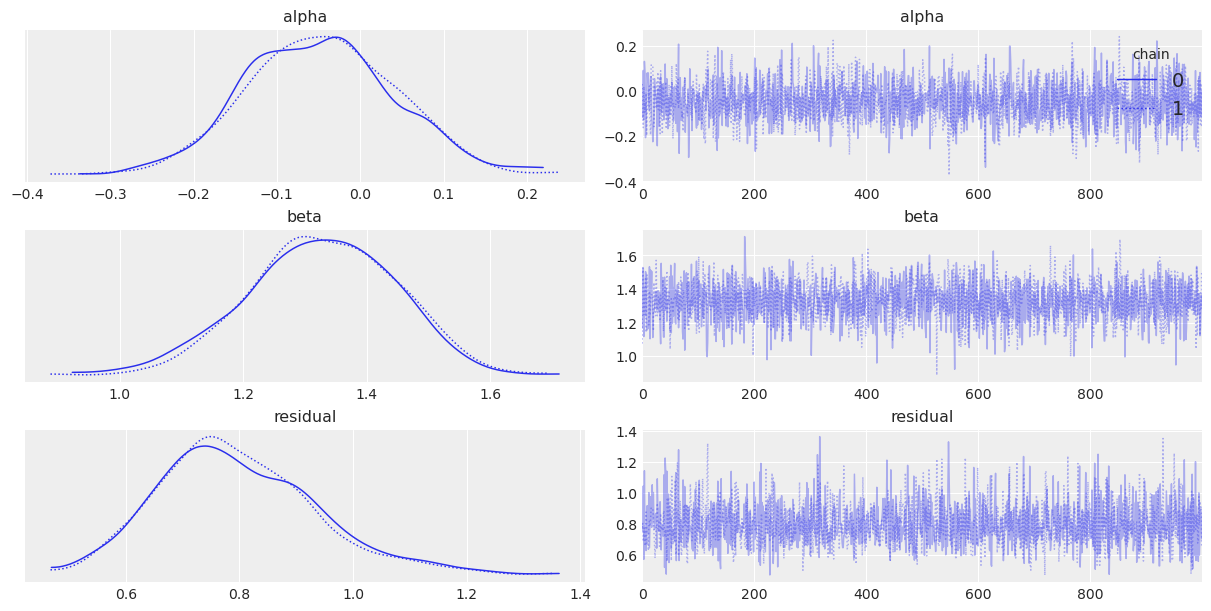

In [35]:
# Subplots on the left show the kernel density estimates (KDE) of the marginal posterior probability distributions of each parameter.
# Subplots on the right show the parameter values that were sampled sequentially in two chains by the NUTS sampler
with model:
  az.plot_trace(idata.posterior, kind='trace', var_names = ['alpha', 'beta', 'residual'], legend=True)

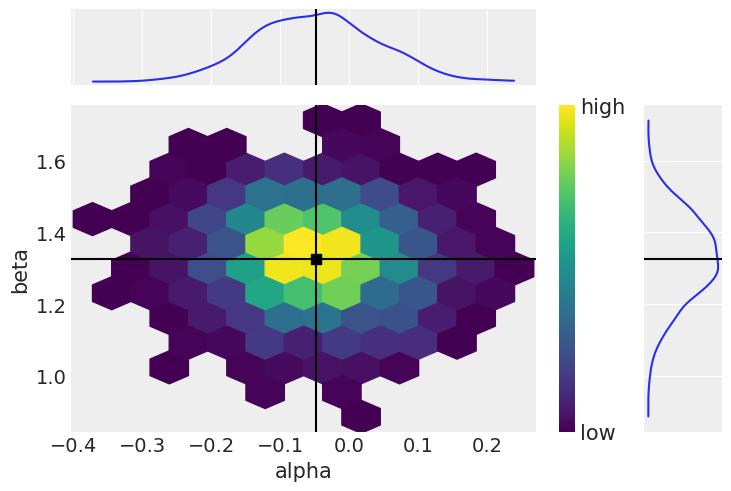

In [36]:
# Plot the joint posterior probability distribution of alpha and beta with their respective means and marginal distributions on the side.
# Hexabin plot below shows little or no linear correlation with the high concentration areas in the heat map forming a cloud.
az.plot_pair(idata.posterior, var_names=['alpha', 'beta'], kind='hexbin', marginals=True, point_estimate='mean', colorbar=True);

In [37]:
# Examine sample statistics of each parameter's posterior marginal distribution, including it's 94% highest density interval (HDI).
display(az.summary(idata, kind='stats', var_names = ['alpha', 'beta', 'residual'], round_to=2, hdi_prob=0.94))

,mean,sd,hdi_3%,hdi_97%
alpha,-0.05,0.09,-0.21,0.12
beta,1.33,0.12,1.11,1.54
residual,0.80,0.14,0.55,1.07


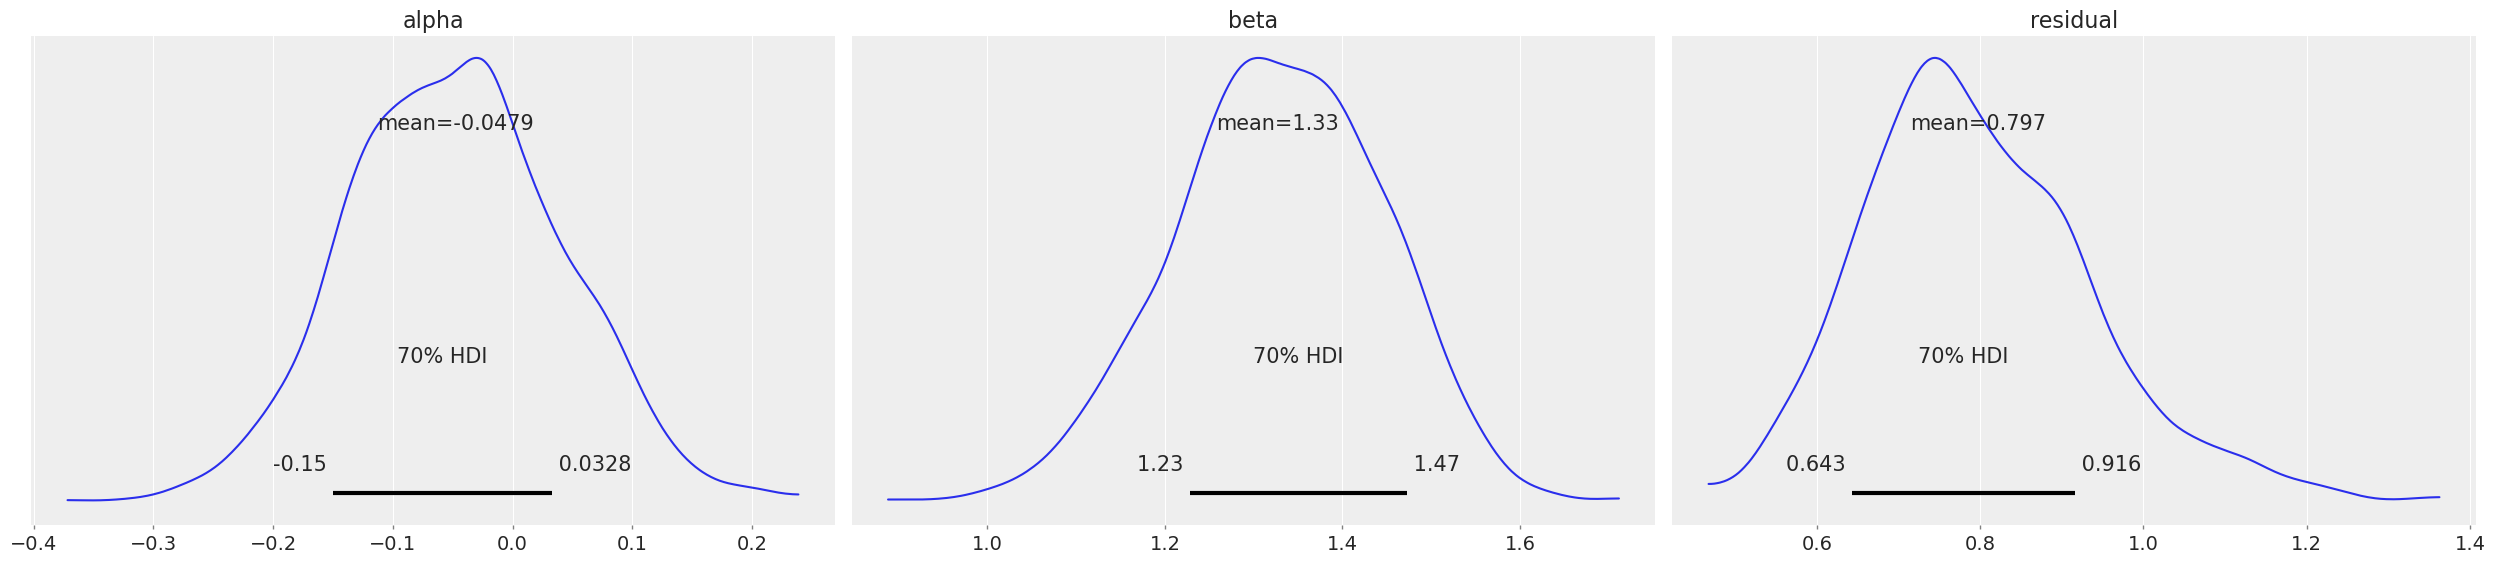

In [38]:
# Plot the marginal posterior distribution of each parameter displaying the above statistics but now within a 70% HDI.
az.plot_posterior(idata, var_names = ['alpha', 'beta', 'residual'], hdi_prob=0.70, round_to=3);

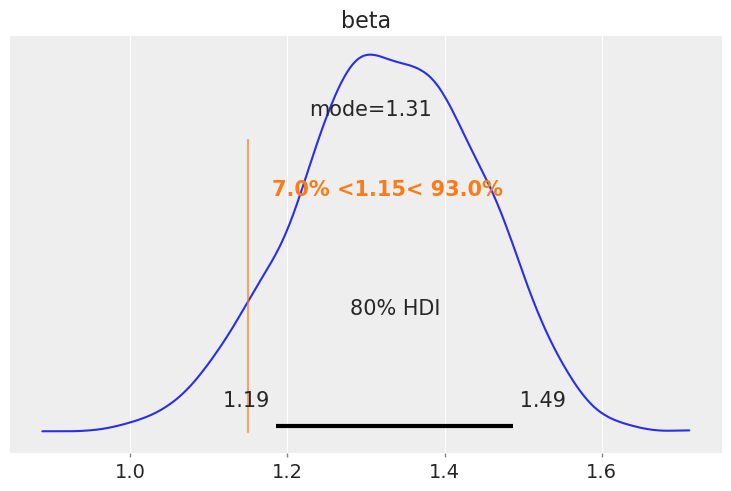

In [39]:
# Evaluate a point estimate for a single parameter using its posterior distribution.
az.plot_posterior(idata, 'beta', ref_val=1.15, hdi_prob=0.80, point_estimate='mode', round_to=3);

In [40]:
# Draw 1000 samples each from two Markov chains of the posterior predictive distribution.
with model:
  pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=101)

Sampling: [target_likelihood]


D:\Programmes\Anaconda\envs\Proba_ML\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

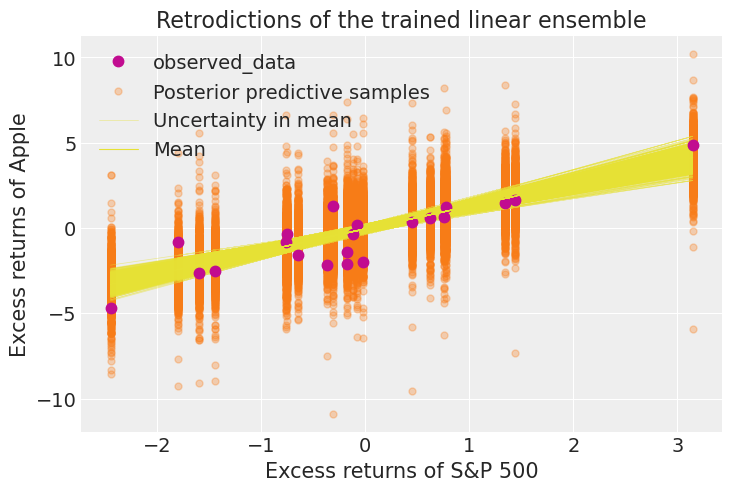

In [41]:
# Generate 2000 linear regression lines based on 1000 draws each from two chains of the posterior distributions of alpha and beta.
# Posterior target values are in 2000 arrays, each with 21 samples, the same number of samples as our training data set.
posterior = idata.posterior
posterior_target = posterior["alpha"] + posterior["beta"] * feature_train

# Posterior_predictive is the data generating distribution of the trained ensemble.
posterior_predictive = idata.posterior_predictive['target_likelihood']

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot epistemic and aleatory uncertainties of trained ensemble's retrodictions.
az.plot_lm(idata=idata, x=feature_train, y=target_train, num_samples=2000, y_model = posterior_target, y_hat=posterior_predictive, axes=ax)

# Label the figure.
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Retrodictions of the trained linear ensemble")
ax.legend(loc='upper left');

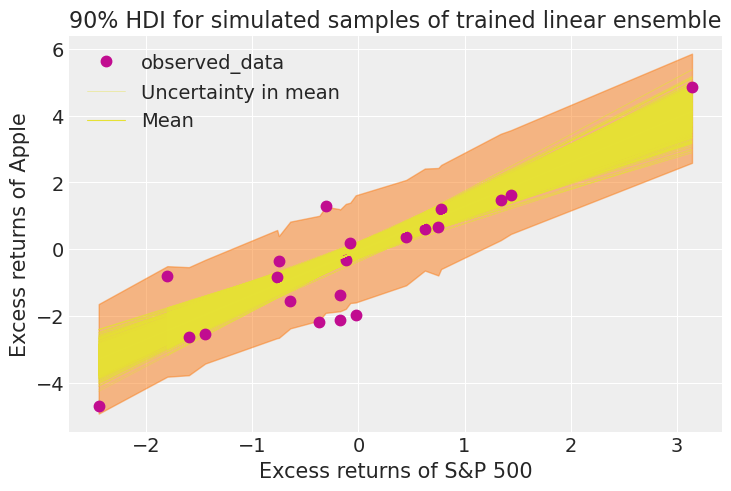

In [42]:
# Plot 90% HDI of trained ensemble.
# This will show the aleatory (data related) and epistemic (parameter related) uncertainty of model output after it is trained.

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot the ensemble of 2000 regression lines to show the epistemic uncertainty around the mean regression line.
az.plot_lm(idata=idata, x=feature_train, y=target_train, num_samples=1000, y_model = posterior_target, axes=ax)

# Plot the posterior predictive data within the 90% HDI band to show both epistemic and aleatory uncertainties.
az.plot_hdi(feature_train, posterior_predictive, hdi_prob=0.90, smooth=False)

#Label the figure
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("90% HDI for simulated samples of trained linear ensemble");

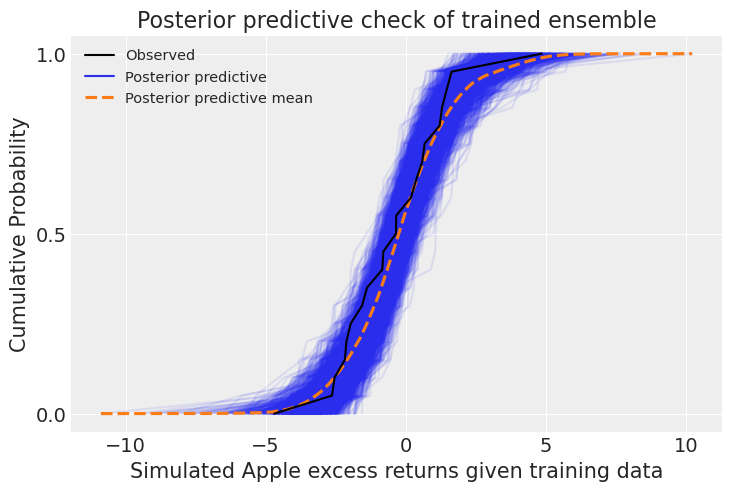

In [43]:
# Conduct a posterior predictive check of the trained linear ensemble.

# Create a figure of subplots.
fig, ax = plt.subplots()

# Plot the posterior predictive check.
az.plot_ppc(idata, group='posterior', kind='cumulative', num_pp_samples=2000, alpha=0.1, ax=ax)

# Label the figure.
ax.set_xlabel("Simulated Apple excess returns given training data")
ax.set_ylabel("Cumulative Probability")
ax.set_title("Posterior predictive check of trained ensemble");

In [44]:
#Evaluate trained ensemble's retrodictions by comparing simulated data with training data.

#Get target values of our training data
target_actual = target_train.values

# Sample the posterior predictive distribution conditioned on training data.
target_predicted = idata.posterior_predictive.stack(sample=("chain", "draw"))['target_likelihood'].values.T

# Compute probabilistic R-squared performance metric.
training_score = az.r2_score(target_actual, target_predicted)
training_score.round(2)

r2        0.65
r2_std    0.09
dtype: float64

In [45]:
# Now we use our trained model to make predictions based on test data. This is the reason we created a mutable data containers earlier.
with model:
    # Swap feature and target training data for their respective test data.
    pm.set_data({'feature': x_test, 'target': y_test})
    # Create two new inference groups, predictions and predictions_constant_data for making predictions based on features in the test data.
    pm.sample_posterior_predictive(idata, return_inferencedata=True, predictions=True, extend_inferencedata=True, random_seed=101)

Sampling: [target_likelihood]


D:\Programmes\Anaconda\envs\Proba_ML\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

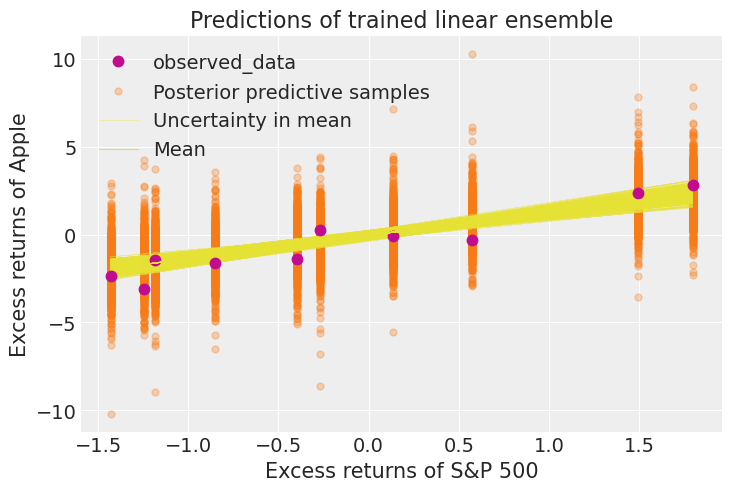

In [46]:
# Get feature and target test data.
feature_test = idata.predictions_constant_data['feature']
target_test = idata.predictions_constant_data['target']

# Prediction target values are in 2000 arrays, each with 10 samples, the same number of samples as our test data set.
# Predict target values based on posterior values of regression parameters and feature test data
prediction_target = posterior["alpha"] + posterior["beta"] * feature_test

# Predictions is the data generating posterior predictive distribution of the trained ensemble based on test data.
simulate_predictions = idata.predictions['target_likelihood']

# Create figure of subplots.
fig, ax = plt.subplots()

# Plot the 2000 regression lines showing the epistemic and aleatory uncertainties of out-of-sample predictions
az.plot_lm(idata=idata, x=feature_test, y=target_test, num_samples=2000, y_model = prediction_target, y_hat=simulate_predictions, axes=ax)

#Label figure
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("Predictions of trained linear ensemble")
ax.legend(loc='upper left');

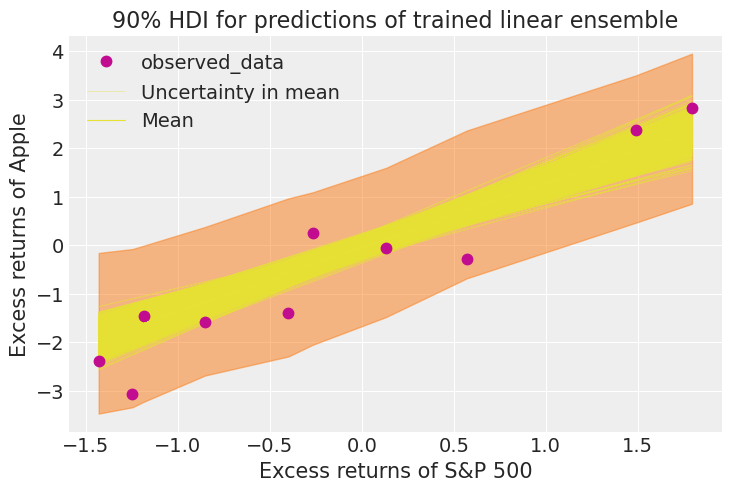

In [47]:
# Plot 90% HDI of trained ensemble.
# This will show the aleatory (data related) and epistemic (parameter related) uncertainty of trained model's predictions based on test data.

# Create figure of subplots.
fig, ax = plt.subplots()


# Plot the ensemble of 2000 regression lines to show the epistemic uncertainty around the mean regression line.
az.plot_lm(idata=idata, x=feature_test, y=target_test, num_samples=2000, y_model = prediction_target, axes=ax)

# Plot the posterior predictive data within the 90% HDI band to show both epistemic and aleatory uncertainties.
az.plot_hdi(feature_test, simulate_predictions, hdi_prob=0.90, smooth=False)

# Label the figure.
ax.set_xlabel("Excess returns of S&P 500")
ax.set_ylabel("Excess returns of Apple")
ax.set_title("90% HDI for predictions of trained linear ensemble")
ax.legend();

In [48]:
# Evaluate out-of-sample predictions of trained ensemble by comparing simulated data with test data.

# Get target values of the test data.
target_actual = target_test.values

# Sample ensemble's predictions based on test data.
target_predicted = idata.predictions.stack(sample=("chain", "draw"))['target_likelihood'].values.T

#  Compute the probabilistic R-squared performance metric.
test_score = az.r2_score(target_actual, target_predicted)
test_score.round(2)

r2        0.69
r2_std    0.13
dtype: float64

# Generative Value at Risk (GVAR)

         Values
count  20000.00
mean      -0.24
std        1.75
min      -10.18
25%       -1.51
50%       -0.43
75%        0.97
max       10.28


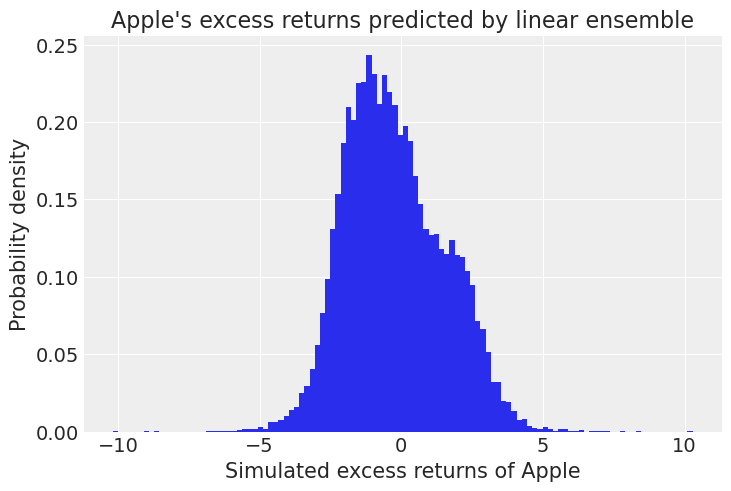

In [49]:
# Flatten posterior predictive xdarray into one numpy array of 20,000 simulated samples.
simulated_data = target_predicted.flatten()

# Create a pandas dataframe to analyze the simulated data.
generated_data = pd.DataFrame(simulated_data, columns=["Values"])

# Print the summary statistics.
print(generated_data.describe().round(2))

#Plot the predicted samples of Apple's excess returns generated by tested linear ensemble.
plt.hist(simulated_data, bins='auto', density=True)
plt.title("Apple's excess returns predicted by linear ensemble")
plt.ylabel('Probability density'), plt.xlabel('Simulated excess returns of Apple');


In [50]:
# Market value of position size in the portfolio.
position_size = 100000

# The loss function is position size * excess returns of Apple for each prediction.
losses = simulated_data/100*position_size

# Expected loss is probability weighted arithmetic mean of all the losses and profits.
expected_loss = np.mean(losses)

# Range of losses predicted by tested linear ensemble.
print("Expected loss on investment of $100,000 is ${:.0f}, with max possible loss of ${:.0f} and max possible profit of ${:.0f}".format(expected_loss, np.min(losses), np.max(losses)))

Expected loss on investment of $100,000 is $-236, with max possible loss of $-10183 and max possible profit of $10283


In [51]:
# Generate a list the 20 worst daily losses predicted by tested linear ensemble.
sorted_returns = generated_data['Values'].sort_values()
sorted_returns.head(20).round(2)

14024   -10.18
2170     -8.96
11889    -8.61
399      -6.81
9841     -6.53
4320     -6.36
1154     -6.27
4410     -6.20
14340    -6.03
234      -5.94
13874    -5.85
600      -5.76
18317    -5.74
8141     -5.71
15794    -5.60
419      -5.58
7062     -5.54
474      -5.53
19887    -5.43
734      -5.40
Name: Values, dtype: float64

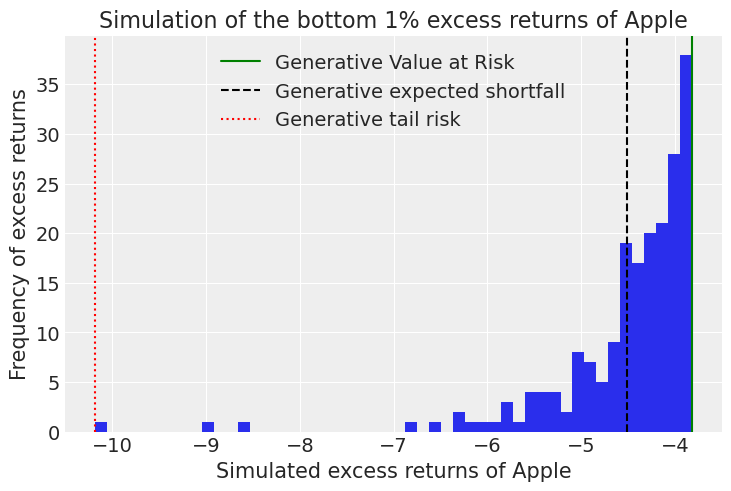

The daily Generative VaR at 0.99% probability is -3.82% implying a dollar loss of $-3818 
The daily Generative expected shortfall at 0.01% probability is -4.51% implying a dollar loss of $-4515
The daily Generative tail risk is -10.18% implying a dollar loss of $-10183


In [52]:
# Compute the first percentile of returns.
probability = 0.99
gvar = sorted_returns.quantile(1-probability)

# Filter the returns that fall below the first percentile
generated_tail = sorted_returns[sorted_returns <= gvar]

# Expected shortfall is the mean of the tail returns.
ges = generated_tail.mean()

# Generated tail risk is the worst possible loss predicted by the linear ensemble
gtr = generated_tail.min()

# Plot a histogram of the worst returns or generated tail risk (GTR)
plt.hist(generated_tail, bins=50)
plt.axvline(x=gvar, color='green', linestyle='solid', label='Generative Value at Risk')
plt.axvline(x=ges, color='black', linestyle='dashed', label='Generative expected shortfall')
plt.axvline(x=gtr, color='red', linestyle='dotted', label='Generative tail risk')
plt.xlabel('Simulated excess returns of Apple')
plt.ylabel('Frequency of excess returns')
plt.title('Simulation of the bottom 1% excess returns of Apple')
plt.legend(loc=0)
plt.show()

print(f"The daily Generative VaR at {probability}% probability is {gvar/100:.2%} implying a dollar loss of ${gvar/100*position_size:.0f} ")
print(f"The daily Generative expected shortfall at {1-probability:.2}% probability is {ges/100:.2%} implying a dollar loss of ${ges/100*position_size:.0f}")
print(f"The daily Generative tail risk is {gtr/100:.2%} implying a dollar loss of ${gtr/100*position_size:.0f}")